In [1]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import warnings
import math
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score,accuracy_score,recall_score,precision_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle, zip_longest, chain
import pickle
from MVDD.MVDD import MVDD
import MVDD.MVDD_Generator as mvGen

%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rc('font', size=12)
warnings.filterwarnings('ignore')

In [28]:
def trainCrossVal(xData, yData, model, numFolds, modelName, showIndividualROC=True):
    
    #make stratified k fold object
    kFold = StratifiedKFold(n_splits=numFolds)
    
    bestAcc = 0

    fprList = []
    tprList = []
    rocList = []

    TPRList = []
    TNRList = []
    PPVList = []
    NPVList = []
    FPRList = []
    FNRList = []
    FDRList = []
    ACCList = []
    AUCList = []

    count = 1
    for train_index, test_index in kFold.split(xData, yData):
        X_train, X_test = xData.iloc[train_index], xData.iloc[test_index]
        y_train, y_test = yData.iloc[train_index], yData.iloc[test_index]

        #fit initial decision tree model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        #Get Accuracy + Confusion Matrix metrics
        cm = confusion_matrix(y_test,y_pred)

        FP = cm.sum(axis=0) - np.diag(cm)
        FN = cm.sum(axis=1) - np.diag(cm)
        TP = np.diag(cm)
        TN = cm.sum() - (FP + FN + TP)

        # Sensitivity, hit rate, recall, or true positive rate
        TPRList.append(TP / (TP + FN))
        # Specificity or true negative rate
        TNRList.append(TN / (TN + FP))
        # Precision or positive predictive value
        PPVList.append(TP / (TP + FP))
        # Negative predictive value
        NPVList.append(TN / (TN + FN))
        # Fall out or false positive rate
        FPRList.append(FP / (FP + TN))
        # False negative rate
        FNRList.append(FN / (TP + FN))
        # False discovery rate
        FDRList.append(FP / (TP + FP))
        # Overall accuracy
        mvddAcc = (TP + TN) / (TP + FP + FN + TN)
        ACCList.append(mvddAcc)

        print("Accuracy MVDD:", mvddAcc)
        print("Averaged acc for all 5 classes:", np.mean(mvddAcc))


        #calculate average roc across all classes
        y_score = label_binarize(y_pred, classes=[1,2,3,4,5])
        y_test = label_binarize(y_test, classes=[1,2,3,4,5])
        fpr, tpr, roc_auc = getClassROC(y_test,y_score)
        fprList.append(fpr)
        tprList.append(tpr)
        rocList.append(roc_auc)

        AUCList.append(list(roc_auc.values()))

        #show individual fold roc curves
        if showIndividualROC:
            getIndividualROCGraph(y_test, y_score, count, modelName)

        count += 1

    aveFPR = getDictionaryAverages(fprList)
    aveTPR = getDictionaryAverages(tprList)
    ave_roc_auc = getDictionaryAverages(rocList, hasList=False)

    getAverageROCGraph(aveFPR, aveTPR, ave_roc_auc, modelName)
    
    print("tpr list", TPRList)
    
    print("\n*****Averaged Final Classification Results*****")
    print("Sensitivity (TPR): %0.3f(±%0.3f)" % (np.nanmean(TPRList), np.nanstd(TPRList) * 2))
    print("Specificity (TNR): %0.3f(±%0.3f)" % (np.nanmean(TNRList), np.nanstd(TNRList) * 2))
    print("Precision (PPV): %0.3f(±%0.3f)" % (np.nanmean(PPVList), np.nanstd(PPVList) * 2))
    print("Negative Predictive Value (NPV): %0.3f(±%0.3f)" % (np.nanmean(NPVList), np.nanstd(NPVList) * 2))
    print("FPR: %0.3f(±%0.3f)" % (np.nanmean(FPRList), np.nanstd(FPRList) * 2))
    print("FNR: %0.3f(±%0.3f)" % (np.nanmean(FNRList), np.nanstd(FNRList) * 2))
    print("Accuracy: %0.3f(±%0.3f)" % (np.nanmean(ACCList), np.nanstd(ACCList) * 2))
    print("Averaged AUC: %0.3f(±%0.3f)" % (np.nanmean(AUCList), np.nanstd(AUCList) * 2))
    
    #Get full metrics
    n = len(xData)

    metricLst = [ np.nanmean(TPRList), np.nanstd(TPRList) * 2, CI(np.nanmean(TPRList), n),
    np.nanmean(TNRList), np.nanstd(TNRList) * 2, CI(np.nanmean(TNRList), n),
    np.nanmean(PPVList), np.nanstd(PPVList) * 2, CI(np.nanmean(PPVList), n),
    np.nanmean(NPVList), np.nanstd(NPVList) * 2, CI(np.nanmean(NPVList), n),
    np.nanmean(FPRList), np.nanstd(FPRList) * 2, CI(np.nanmean(FPRList), n),
    np.nanmean(FNRList), np.nanstd(FNRList) * 2, CI(np.nanmean(FNRList), n),
    np.nanmean(ACCList), np.nanstd(ACCList) * 2, CI(np.nanmean(ACCList), n),
    np.nanmean(AUCList), np.nanstd(AUCList) * 2, CI(np.nanmean(AUCList), n) ]
    
    return metricLst

# Return 95% Confidence Interval for Value
def CI(val, n):
    ci = 1.96 * math.sqrt(abs(val - (1 - val)) / n)
    return ci
    
def getClassROC(y_test, y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(5):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(5)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(5):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= 5

    return fpr, tpr, roc_auc

def getIndividualROCGraph(y_test, y_score, foldNum, modelName):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(5):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(5)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(5):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= 5

    plt.figure(figsize=(10, 8))
    plt.rcParams.update({'font.size': 18})
    # colors = cycle(['aqua', 'darkorange', 'cornflowerblue','palegreen', 'mistyrose'])
    colors = cycle(['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple'])
    for i, color in zip(range(5), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='Class {0} AUC = {1:0.2f})'
                 ''.format(i+1, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1 - Specificity (False Positive Rate)')
    plt.ylabel('Sensitivity (True Positive Rate)')
    # plt.title('ROC Curve for Each Score Classification Fold ' + str(foldNum))
    plt.legend(loc="lower right")

    plt.savefig("Model Comparison/Graphs/" + modelName + "ROC for Fold " + str(foldNum) + ".png")
    plt.show()
    
def getDictionaryAverages(dictList, hasList=True):
    d = {}
    for k in dictList[0].keys():
        d[k] = tuple(d[k] for d in dictList)

    if hasList:
        finalDict = {}
        #create average
        for key, value in d.items():
            finalDict[key] = list(map(mapAvg, zip_longest(*value)))
    else:
        finalDict = {}

        for key,value in d.items():
            finalDict[key] = np.mean(value)

    return finalDict

#Helper method to get dictinoary averages
def mapAvg(x):
    x = [i for i in x if i is not None]
    return sum(x, 0.0) / len(x)

def getAverageROCGraph(fpr, tpr, roc_auc, modelName):
    plt.figure(figsize=(10, 8))
    # plt.rc('font', size=14)
    plt.rcParams.update({'font.size': 18})
    # colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'palegreen', 'mistyrose'])
    colors = cycle(['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple'])
    for i, color in zip(range(5), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='Class {0} AUC = {1:0.2f})'
                       ''.format(i + 1, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1 - Specificity (False Positive Rate)')
    plt.ylabel('Sensitivity (True Positive Rate)')
    # plt.title('Averaged ROC Curve for Each Score Classification')
    plt.legend(loc="lower right")
    plt.savefig("Model Comparison/Graphs/"+ modelName + "Averaged_ROC.png")
    plt.show()

# Hemodynamics

In [32]:
#Load original dataframes
hemoData = pd.read_csv('Data/Preprocessed Data/ESCAPE_Hemo.csv', index_col='ID')
allScores = hemoData['Score']
death = hemoData['ScoreDeath']
rehosp = hemoData['ScoreRehosp']
readm = hemoData['ScoreReadmission']
hemoData

Age  Gender  Race   EjF   RAP   PAS   PAD  PAMN  PCWP    CO  ...  \
ID                                                                   ...   
72     88.0     2.0   1.0  25.0  24.0  42.0  24.0  30.0  36.0  2.20  ...   
72     88.0     2.0   1.0  25.0  18.0  42.0  24.0  30.0  24.0  3.10  ...   
81     69.0     1.0   1.0  20.0  10.0  40.0  20.0  27.0  18.0  4.52  ...   
81     69.0     1.0   1.0  20.0  12.0  35.0  15.0  25.0  17.0  4.65  ...   
814    58.0     1.0   1.0   NaN   3.0  51.0  19.0  30.0  18.0  4.10  ...   
...     ...     ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
98508  57.0     1.0  98.0  30.0   NaN   NaN   NaN   NaN   NaN   NaN  ...   
99302  41.0     1.0   2.0  15.0  19.0  87.0  37.0  54.0  44.0  3.90  ...   
99302  41.0     1.0   2.0  15.0  11.0  70.0  28.0  44.0  28.0  5.30  ...   
99935  64.0     2.0   1.0  20.0   8.0  49.0  29.0  31.0  15.0  4.00  ...   
99935  64.0     2.0   1.0  20.0   8.0  52.0  24.0  39.0  24.0  5.60  ...   

            RAT   PPRatio       PAPi      SAPi   CPP    PRAPRat  Score  \
ID                                                                       
72     0.666667  0.266667   0.750000  0.777778  50.0   1.166667      5   
72     0.750000  0.272727   1.000000  1.000000  50.0   1.333333      5   
81     0.555556  0.242857   2.000000  0.944444  45.0   1.700000      3   
81     0.705882  0.571429   1.666667  2.352941  45.0   3.333333      3   
814    0.166667  0.566667  10.666667  1.888889  44.0  11.333333      1   
...         ...       ...        ...       ...   ...        ...    ...   
98508       NaN       NaN        NaN       NaN  37.0        NaN      1   
99302  0.431818  0.642857   2.631579  1.227273  13.0   2.842105      4   
99302  0.392857  1.088608   3.818182  3.071429  13.0   7.818182      4   
99935  0.533333  1.253333   2.500000  6.266667  30.0  11.750000      2   
99935  0.333333  0.888889   3.500000  3.000000  30.0   9.000000      2   

       ScoreDeath  ScoreRehosp  ScoreReadmission  
ID                                                
72              5            5                 4  
72              5            5                 4  
81              3            3                 3  
81              3            3                 3  
814             1            1                 1  
...           ...          ...               ...  
98508           1            1                 1  
99302           4            4                 5  
99302           4            4                 5  
99935           2            2                 2  
99935           2            2                 2  

[418 rows x 32 columns]

In [33]:
# Preprocess and create training and testing sets
hemo = hemoData.drop('Score', axis=1)
hemo = hemo.drop('ScoreDeath', axis=1)
hemo = hemo.drop('ScoreRehosp', axis=1)
hemo = hemo.drop('ScoreReadmission', axis=1)
hemo = hemo.replace(np.inf, 0)
hemo = hemo.fillna(0)

## DeLvTxOutcome

In [34]:
xData = hemo
yData = death
xData.shape, yData.shape

modelName = "Hemo_DeLvTx_"

Accuracy MVDD: [0.64285714 0.71428571 0.53571429 0.80952381 0.94047619]
Averaged acc for all 5 classes: 0.7285714285714286


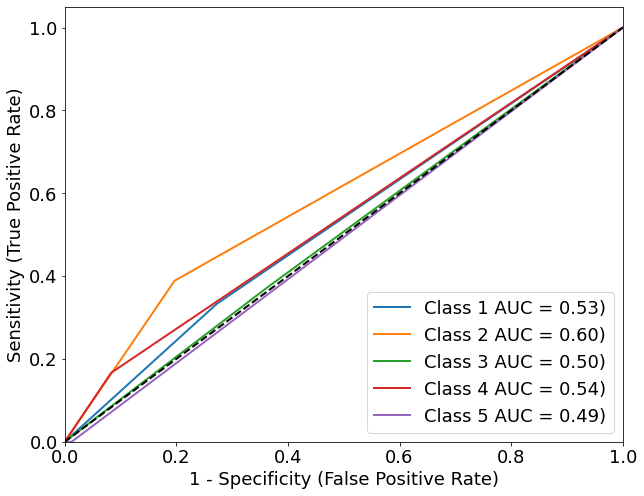

Accuracy MVDD: [0.60714286 0.72619048 0.5        0.82142857 0.94047619]
Averaged acc for all 5 classes: 0.7190476190476189


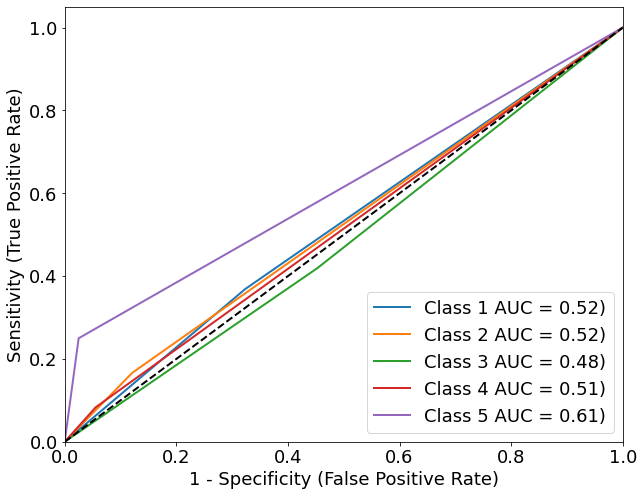

Accuracy MVDD: [0.66666667 0.75       0.54761905 0.86904762 0.95238095]
Averaged acc for all 5 classes: 0.7571428571428571


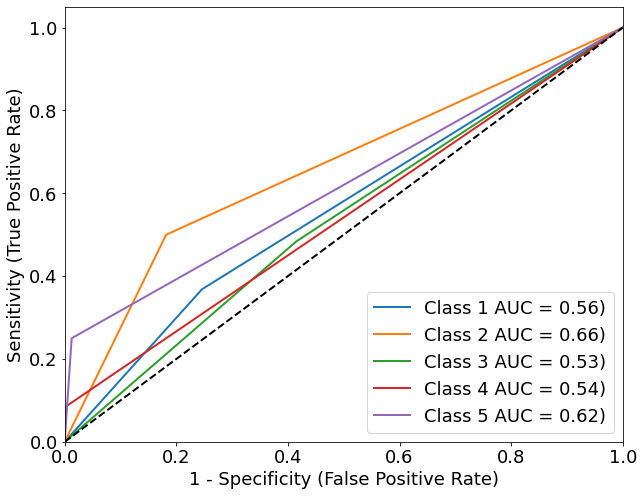

Accuracy MVDD: [0.65060241 0.60240964 0.53012048 0.79518072 0.92771084]
Averaged acc for all 5 classes: 0.7012048192771084


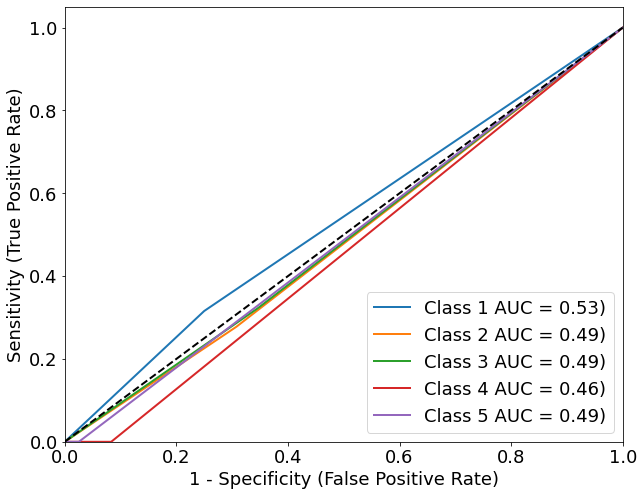

Accuracy MVDD: [0.69879518 0.6746988  0.4939759  0.81927711 0.93975904]
Averaged acc for all 5 classes: 0.7253012048192771


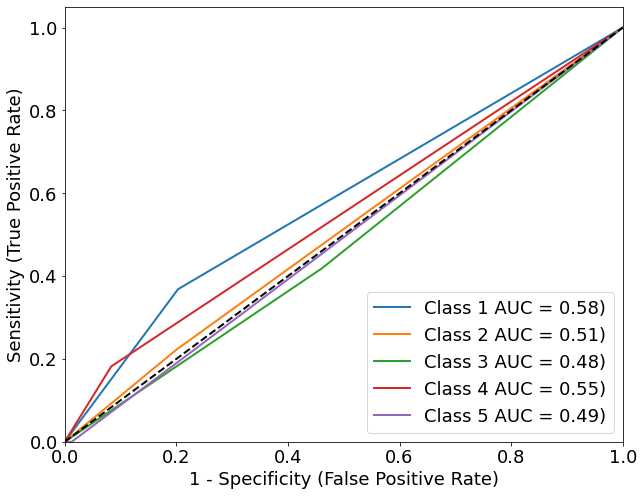

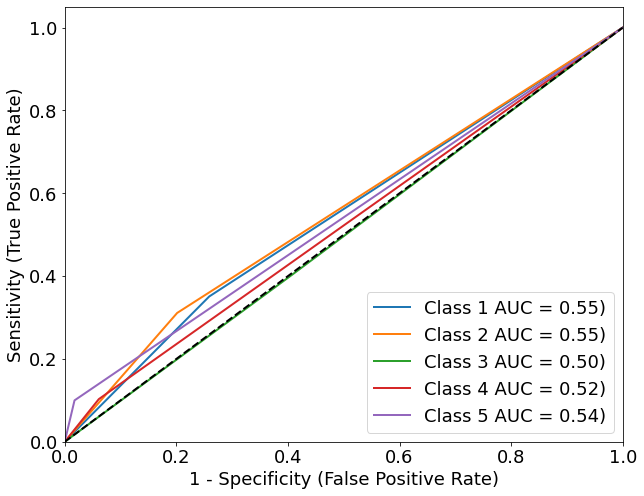

tpr list [array([0.33333333, 0.38888889, 0.375     , 0.16666667, 0.        ]), array([0.36842105, 0.16666667, 0.41935484, 0.08333333, 0.25      ]), array([0.36842105, 0.5       , 0.48387097, 0.08333333, 0.25      ]), array([0.31578947, 0.27777778, 0.32258065, 0.        , 0.        ]), array([0.36842105, 0.22222222, 0.41935484, 0.18181818, 0.        ])]

*****Averaged Final Classification Results*****
Sensitivity (TPR): 0.254(±0.308)
Specificity (TNR): 0.811(±0.293)
Precision (PPV): 0.292(±0.395)
Negative Predictive Value (NPV): 0.811(±0.220)
FPR: 0.189(±0.293)
FNR: 0.746(±0.308)
Accuracy: 0.726(±0.294)
Averaged AUC: 0.532(±0.098)


In [35]:
# base model knn
knn = KNeighborsClassifier()
knn_metrics = trainCrossVal(xData, yData, model=knn, numFolds=5, modelName=modelName + "KNN", showIndividualROC=True)


Accuracy MVDD: [0.70238095 0.94047619 0.5952381  0.75       0.94047619]
Averaged acc for all 5 classes: 0.7857142857142858


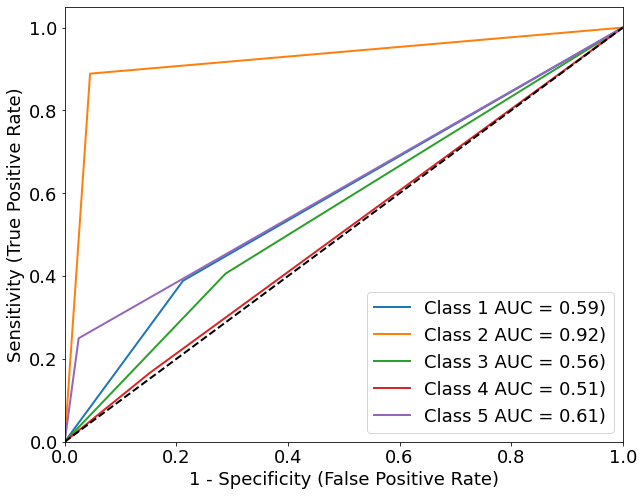

Accuracy MVDD: [0.77380952 0.92857143 0.61904762 0.77380952 0.92857143]
Averaged acc for all 5 classes: 0.8047619047619048


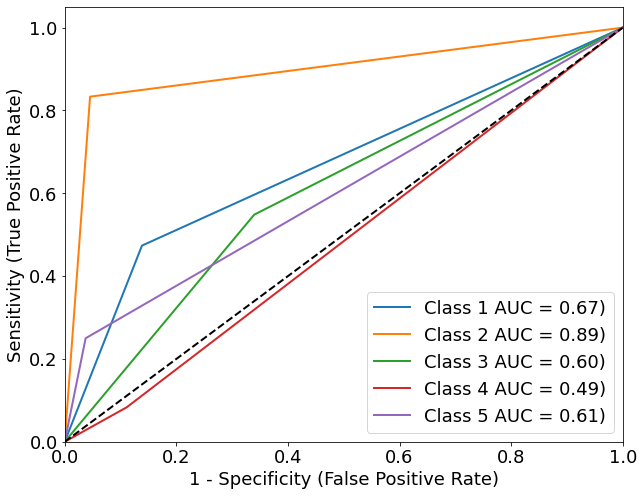

Accuracy MVDD: [0.75       0.95238095 0.60714286 0.78571429 0.95238095]
Averaged acc for all 5 classes: 0.8095238095238095


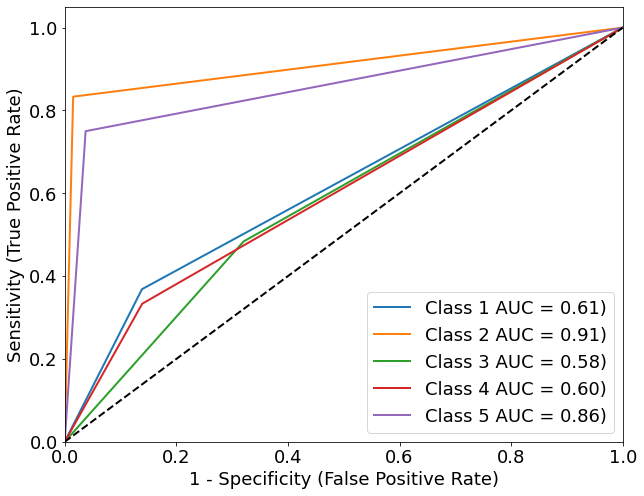

Accuracy MVDD: [0.72289157 0.98795181 0.60240964 0.78313253 0.98795181]
Averaged acc for all 5 classes: 0.8168674698795181


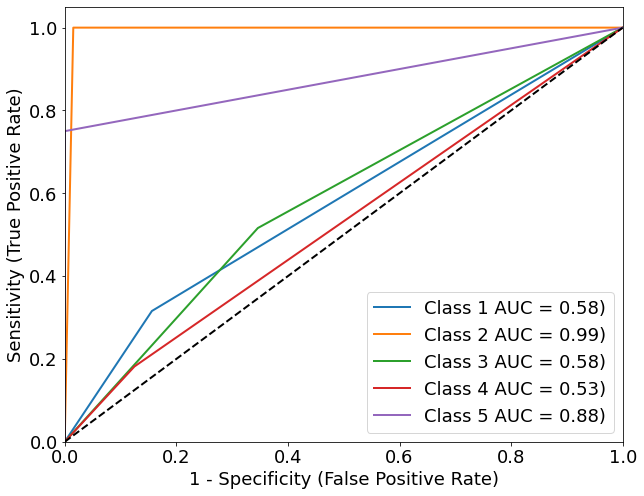

Accuracy MVDD: [0.79518072 0.89156627 0.72289157 0.75903614 0.89156627]
Averaged acc for all 5 classes: 0.8120481927710845


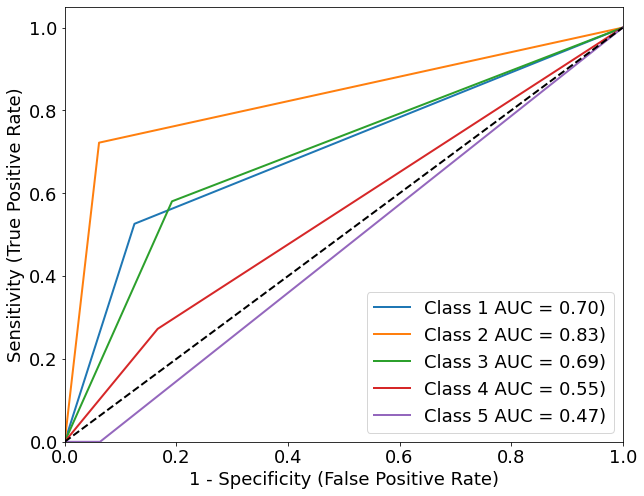

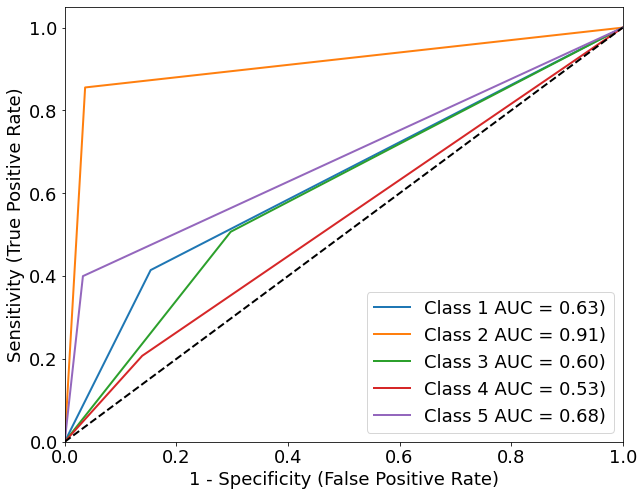


*****Averaged Final Classification Results*****
Sensitivity (TPR): 0.477(±0.523)
Specificity (TNR): 0.868(±0.204)
Precision (PPV): 0.483(±0.545)
Negative Predictive Value (NPV): 0.868(±0.199)
FPR: 0.132(±0.204)
FNR: 0.523(±0.523)
Accuracy: 0.806(±0.249)
Averaged AUC: 0.673(±0.303)


In [7]:
# base model decision tree

dt = DecisionTreeClassifier(random_state=100, max_depth=None)
dt_metrics = trainCrossVal(xData, yData, model=dt, numFolds=5, modelName=modelName+"DecisionTree", showIndividualROC=True)


Accuracy MVDD: [0.80952381 0.95238095 0.70238095 0.79761905 0.95238095]
Averaged acc for all 5 classes: 0.8428571428571429


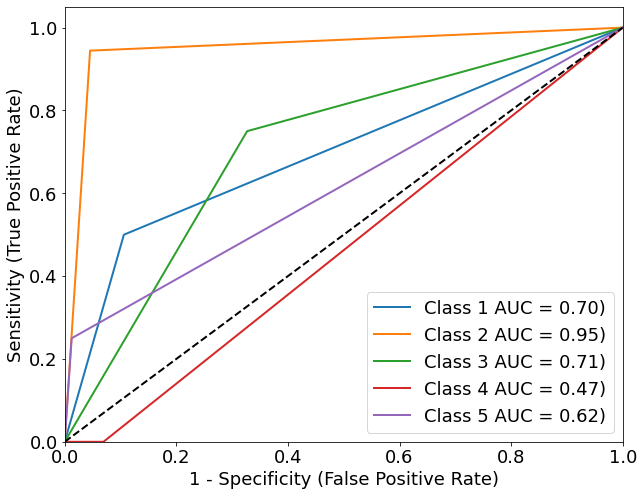

Accuracy MVDD: [0.71428571 0.94047619 0.57142857 0.85714286 0.94047619]
Averaged acc for all 5 classes: 0.8047619047619048


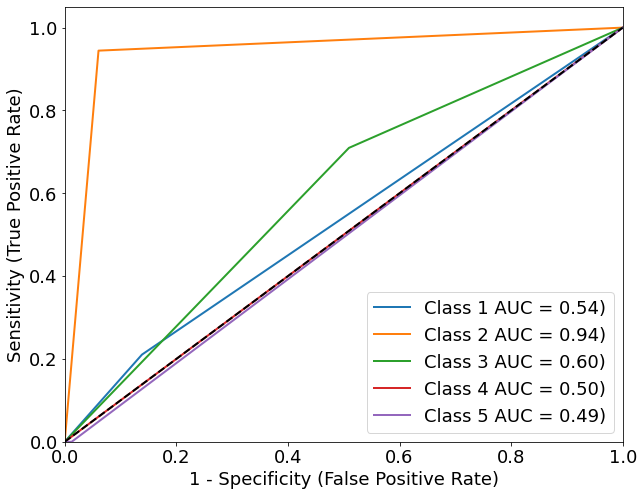

Accuracy MVDD: [0.80952381 0.95238095 0.69047619 0.85714286 0.95238095]
Averaged acc for all 5 classes: 0.8523809523809524


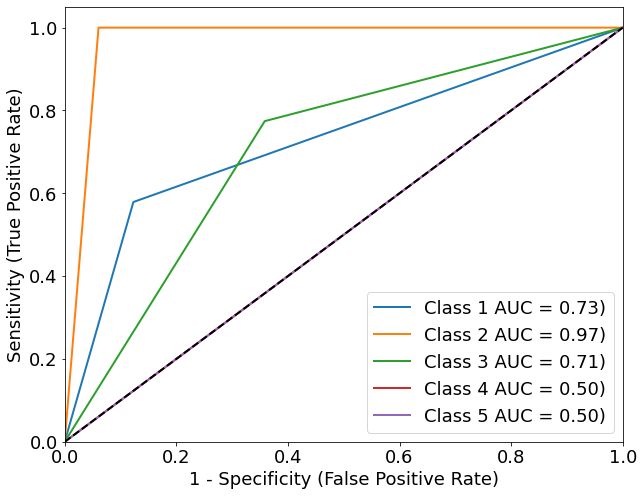

Accuracy MVDD: [0.75903614 0.93975904 0.63855422 0.8313253  0.93975904]
Averaged acc for all 5 classes: 0.8216867469879517


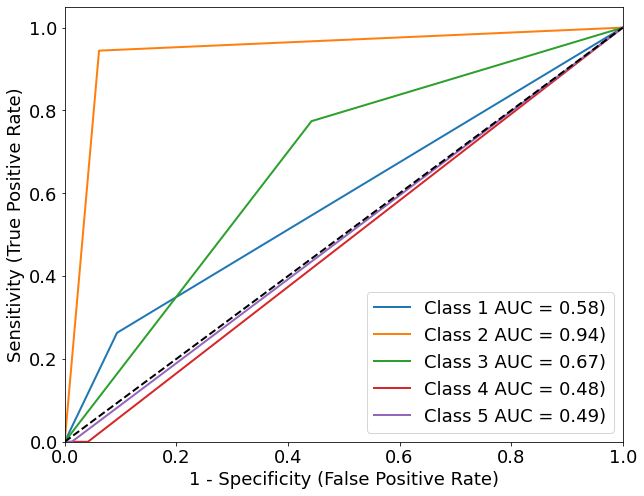

Accuracy MVDD: [0.80722892 0.93975904 0.6746988  0.81927711 0.93975904]
Averaged acc for all 5 classes: 0.836144578313253


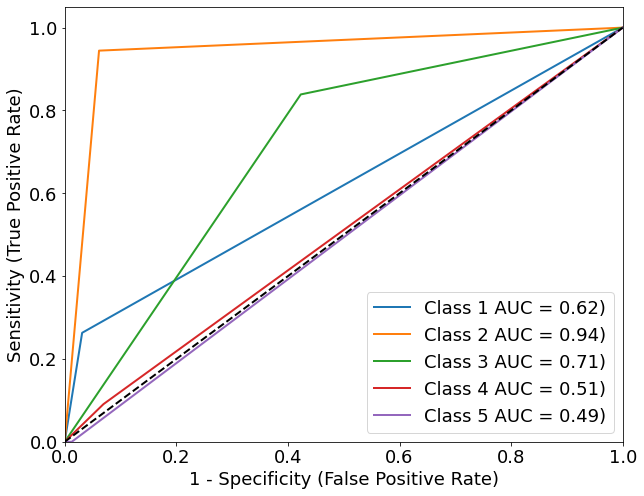

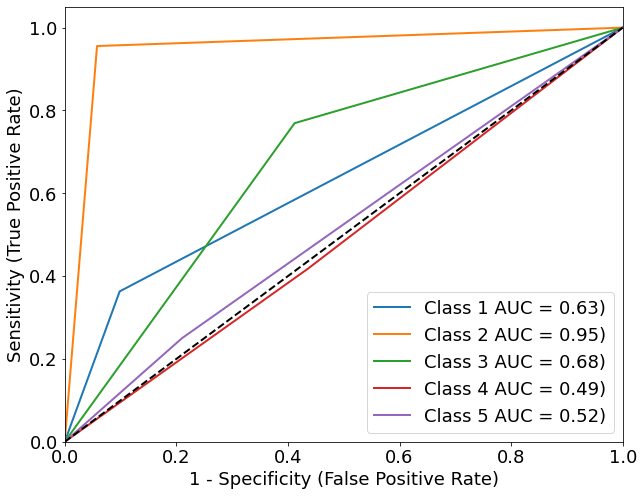


*****Averaged Final Classification Results*****
Sensitivity (TPR): 0.431(±0.772)
Specificity (TNR): 0.877(±0.304)
Precision (PPV): 0.456(±0.594)
Negative Predictive Value (NPV): 0.888(±0.147)
FPR: 0.123(±0.304)
FNR: 0.569(±0.772)
Accuracy: 0.832(±0.226)
Averaged AUC: 0.654(±0.337)


In [8]:
# random forest
rf = RandomForestClassifier(random_state=100, n_estimators=1000)
rf_metrics = trainCrossVal(xData, yData, model=rf, numFolds=5, modelName=modelName+"RandomForest", showIndividualROC=True)


In [9]:
# Make dataframe of stats
columns=["TPR", "TPR SD", "TPR CI", "TNR", "TNR SD", "TNR CI", "PPV", "PPV SD", "PPV CI",
             "NPV", "NPV SD", "NPV CI", "FPR", "FPR SD", "FPR CI", "FNR", "FNR SD", "FNR CI",
             "Acc", "Acc SD", "Acc CI", "AUC", "AUC SD", "AUC CI"]

mets = pd.DataFrame([knn_metrics, dt_metrics, rf_metrics], columns=columns)
mets.index = ["KNN", "DT", "RF"]
mets.to_csv("Model Comparison/" + modelName + "Results.csv")
mets

TPR    TPR SD    TPR CI       TNR    TNR SD    TNR CI       PPV  \
KNN  0.253810  0.308119  0.067269  0.810508  0.292851  0.075547  0.291974   
DT   0.476962  0.522776  0.020578  0.868067  0.204225  0.082252  0.482977   
RF   0.431250  0.772071  0.035548  0.877062  0.303589  0.083251  0.455735   

       PPV SD    PPV CI       NPV  ...    FPR CI       FNR    FNR SD  \
KNN  0.394758  0.061836  0.810754  ...  0.075547  0.746190  0.308119   
DT   0.544813  0.017689  0.867922  ...  0.082252  0.523038  0.522776   
RF   0.593814  0.028524  0.888189  ...  0.083251  0.568750  0.772071   

       FNR CI       Acc    Acc SD    Acc CI       AUC    AUC SD    AUC CI  
KNN  0.067269  0.726254  0.294094  0.064488  0.532159  0.097572  0.024313  
DT   0.020578  0.805783  0.248658  0.074970  0.672514  0.303405  0.056311  
RF   0.035548  0.831566  0.225654  0.078067  0.654156  0.337273  0.053231  

[3 rows x 24 columns]

## Rehosp Outcome

In [10]:
xData = hemo
yData = rehosp
xData.shape, yData.shape

modelName = "Hemo_Rehosp_"

Accuracy MVDD: [0.64285714 0.71428571 0.53571429 0.80952381 0.94047619]
Averaged acc for all 5 classes: 0.7285714285714286


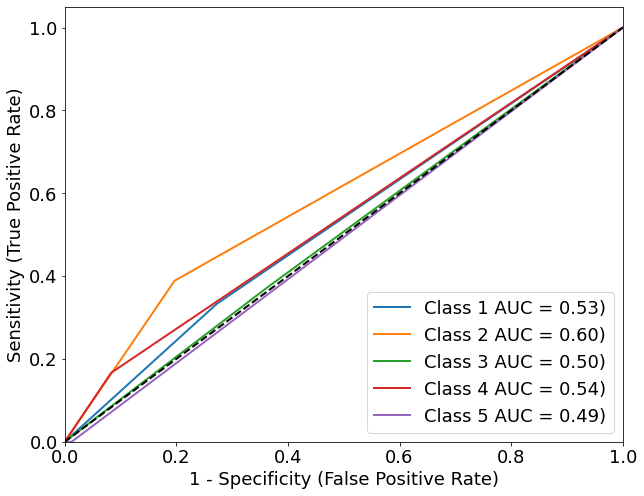

Accuracy MVDD: [0.60714286 0.72619048 0.5        0.82142857 0.94047619]
Averaged acc for all 5 classes: 0.7190476190476189


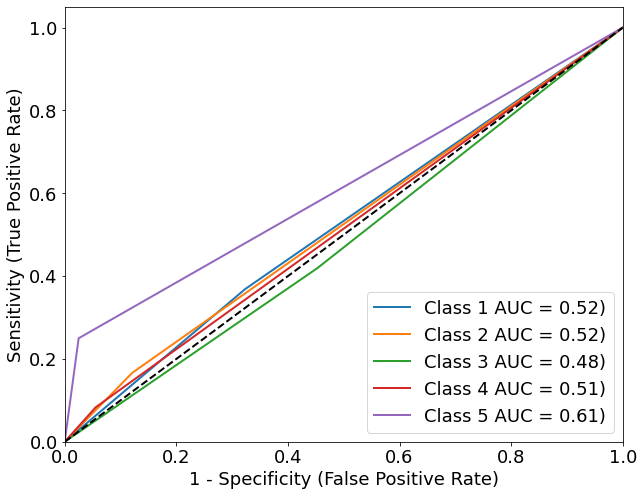

Accuracy MVDD: [0.66666667 0.75       0.54761905 0.86904762 0.95238095]
Averaged acc for all 5 classes: 0.7571428571428571


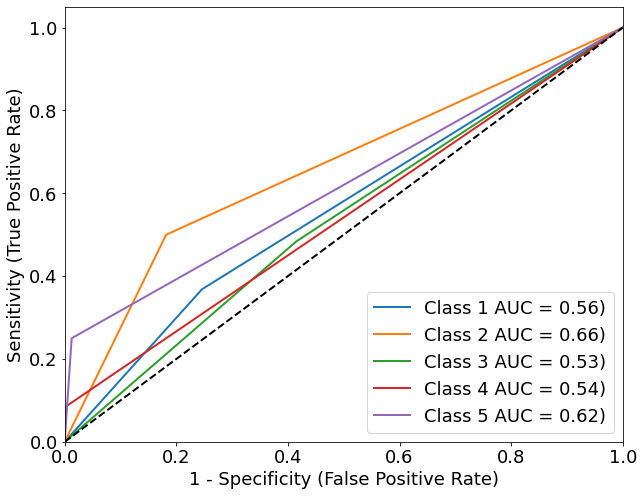

Accuracy MVDD: [0.65060241 0.60240964 0.53012048 0.79518072 0.92771084]
Averaged acc for all 5 classes: 0.7012048192771084


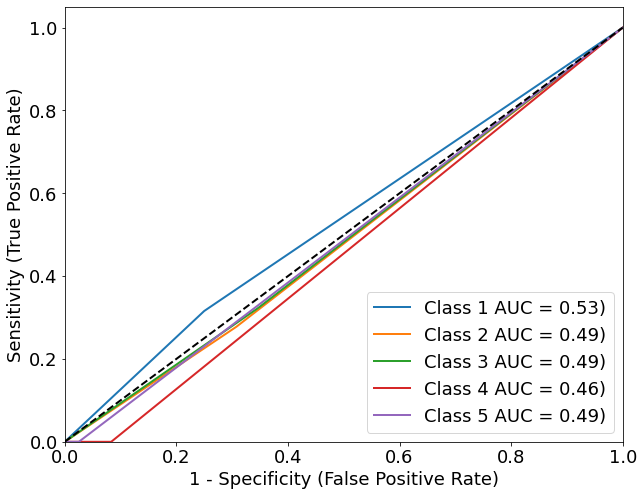

Accuracy MVDD: [0.69879518 0.6746988  0.4939759  0.81927711 0.93975904]
Averaged acc for all 5 classes: 0.7253012048192771


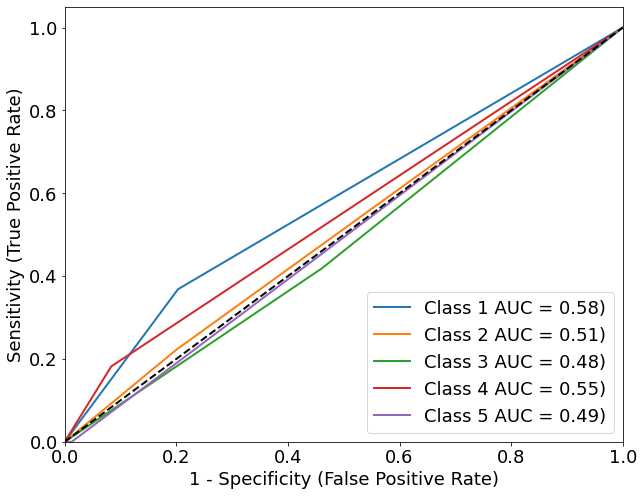

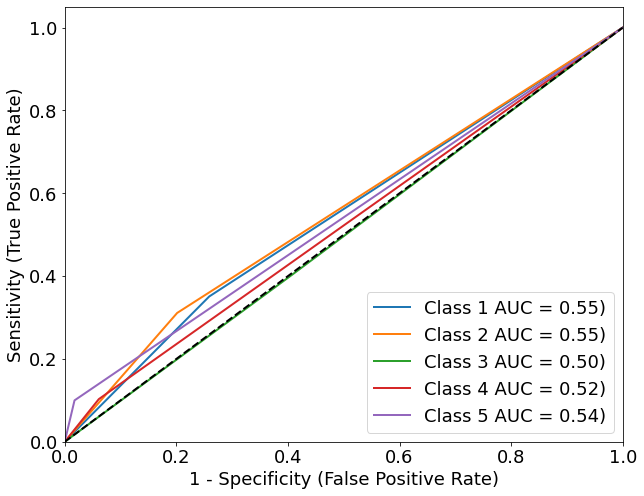


*****Averaged Final Classification Results*****
Sensitivity (TPR): 0.254(±0.308)
Specificity (TNR): 0.811(±0.293)
Precision (PPV): 0.292(±0.395)
Negative Predictive Value (NPV): 0.811(±0.220)
FPR: 0.189(±0.293)
FNR: 0.746(±0.308)
Accuracy: 0.726(±0.294)
Averaged AUC: 0.532(±0.098)


In [11]:
# base model knn
knn = KNeighborsClassifier()
knn_metrics = trainCrossVal(xData, yData, model=knn, numFolds=5, modelName=modelName + "KNN", showIndividualROC=True)


Accuracy MVDD: [0.70238095 0.94047619 0.5952381  0.75       0.94047619]
Averaged acc for all 5 classes: 0.7857142857142858


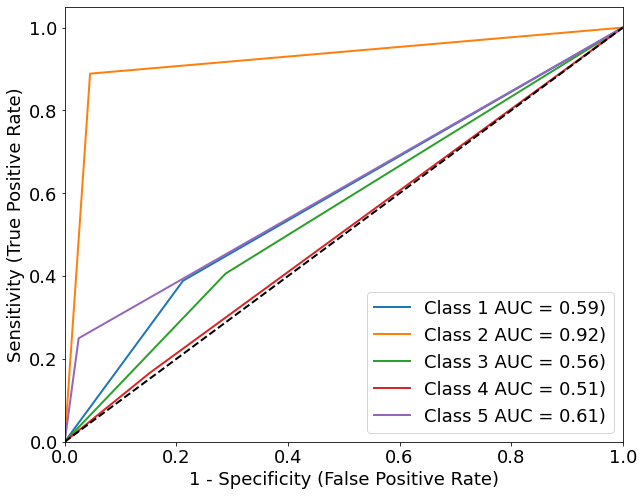

Accuracy MVDD: [0.77380952 0.92857143 0.61904762 0.77380952 0.92857143]
Averaged acc for all 5 classes: 0.8047619047619048


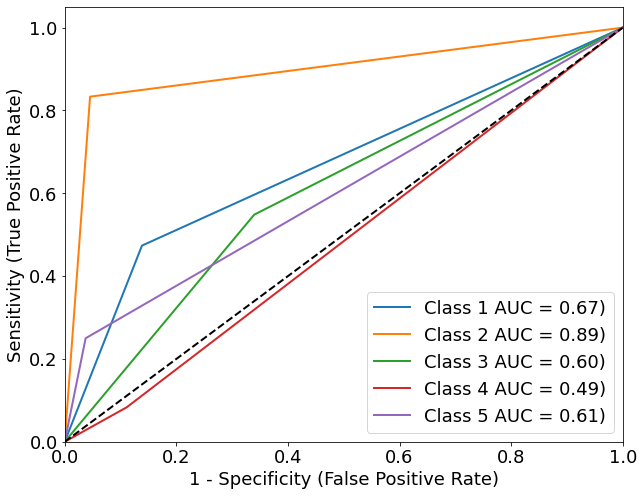

Accuracy MVDD: [0.75       0.95238095 0.60714286 0.78571429 0.95238095]
Averaged acc for all 5 classes: 0.8095238095238095


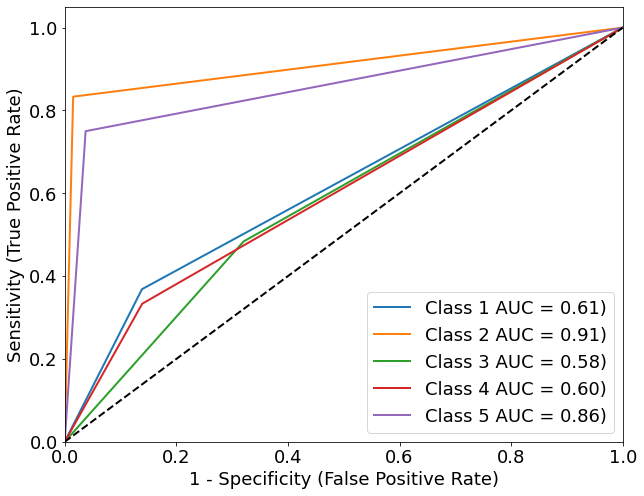

Accuracy MVDD: [0.72289157 0.98795181 0.60240964 0.78313253 0.98795181]
Averaged acc for all 5 classes: 0.8168674698795181


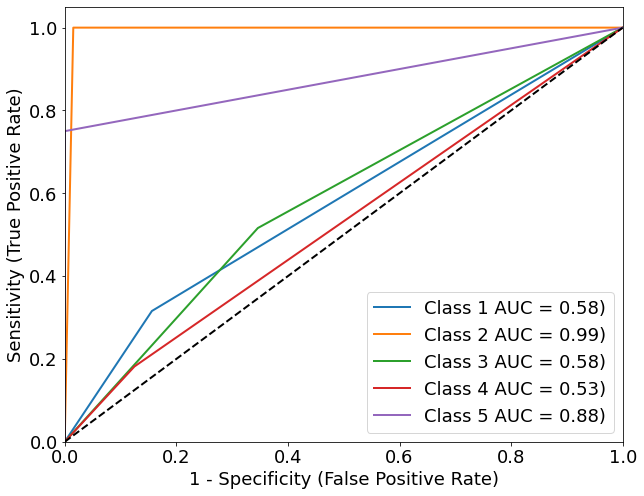

Accuracy MVDD: [0.79518072 0.89156627 0.72289157 0.75903614 0.89156627]
Averaged acc for all 5 classes: 0.8120481927710845


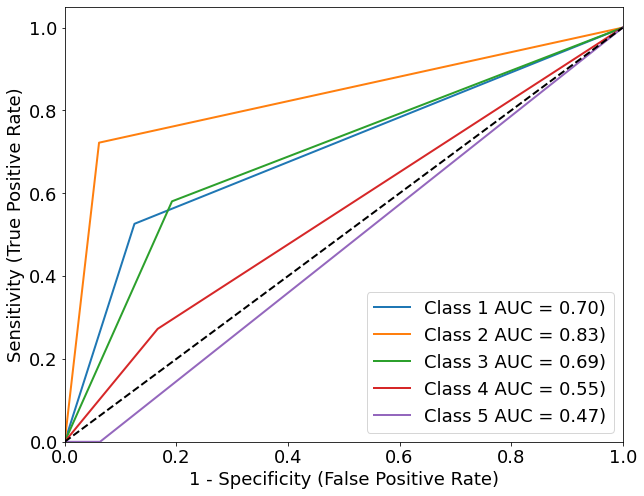

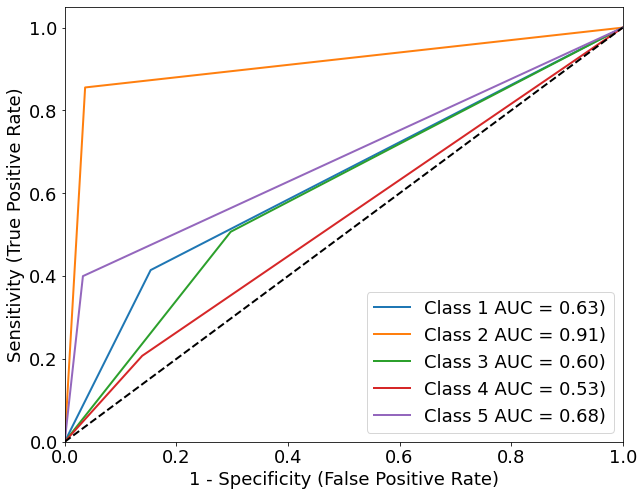


*****Averaged Final Classification Results*****
Sensitivity (TPR): 0.477(±0.523)
Specificity (TNR): 0.868(±0.204)
Precision (PPV): 0.483(±0.545)
Negative Predictive Value (NPV): 0.868(±0.199)
FPR: 0.132(±0.204)
FNR: 0.523(±0.523)
Accuracy: 0.806(±0.249)
Averaged AUC: 0.673(±0.303)


In [12]:
# base model decision tree

dt = DecisionTreeClassifier(random_state=100, max_depth=None)
dt_metrics = trainCrossVal(xData, yData, model=dt, numFolds=5, modelName=modelName+"DecisionTree", showIndividualROC=True)


Accuracy MVDD: [0.80952381 0.95238095 0.70238095 0.79761905 0.95238095]
Averaged acc for all 5 classes: 0.8428571428571429


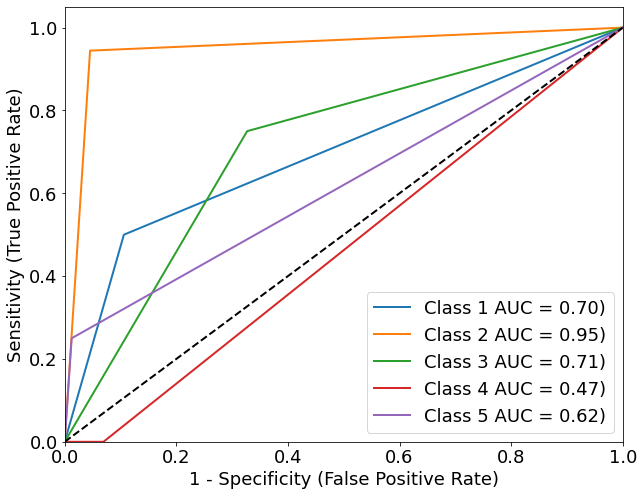

Accuracy MVDD: [0.71428571 0.94047619 0.57142857 0.85714286 0.94047619]
Averaged acc for all 5 classes: 0.8047619047619048


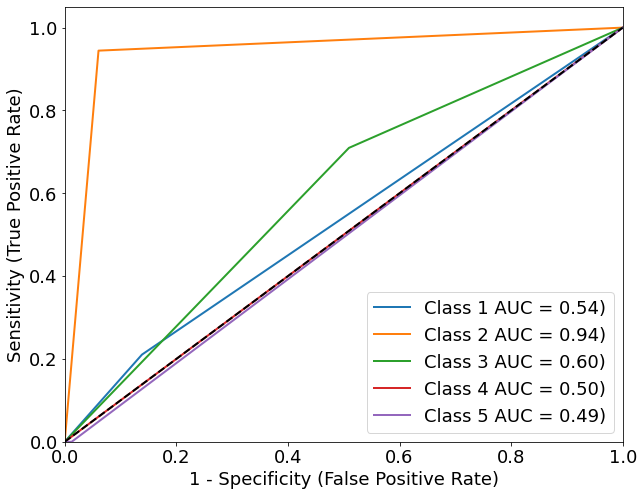

Accuracy MVDD: [0.80952381 0.95238095 0.69047619 0.85714286 0.95238095]
Averaged acc for all 5 classes: 0.8523809523809524


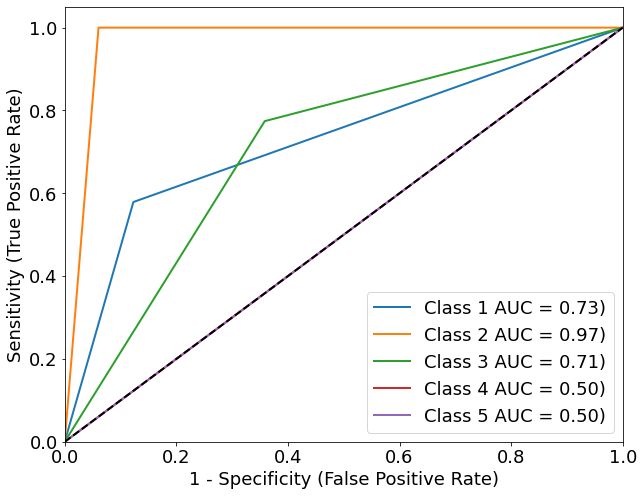

Accuracy MVDD: [0.75903614 0.93975904 0.63855422 0.8313253  0.93975904]
Averaged acc for all 5 classes: 0.8216867469879517


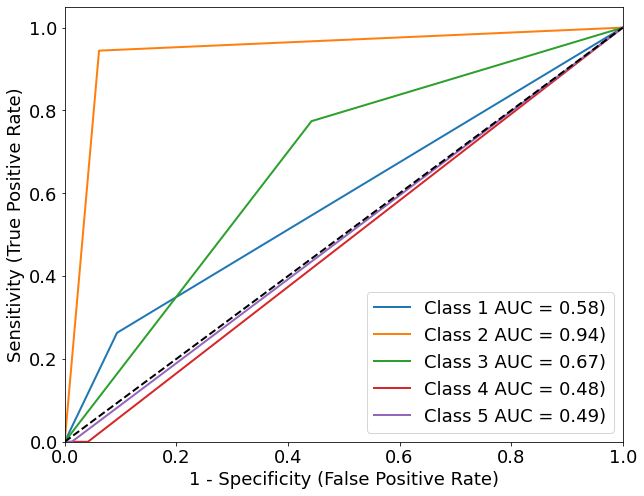

Accuracy MVDD: [0.80722892 0.93975904 0.6746988  0.81927711 0.93975904]
Averaged acc for all 5 classes: 0.836144578313253


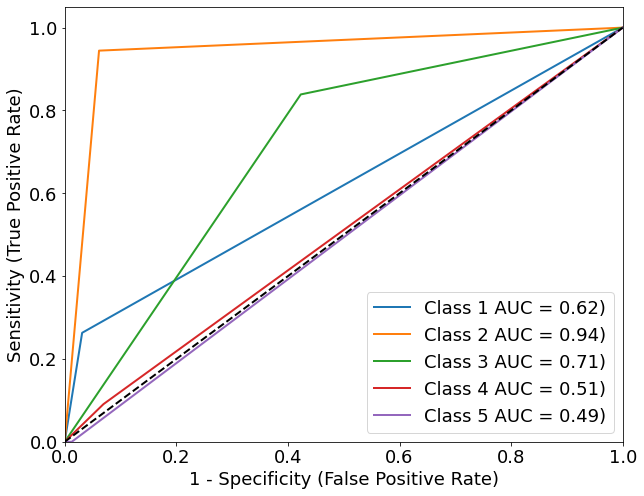

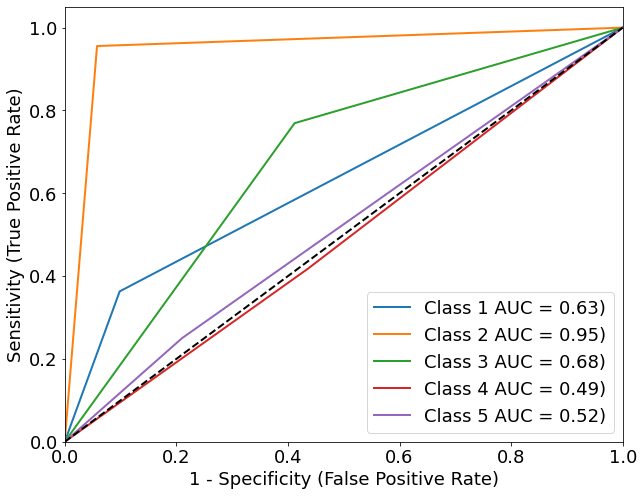


*****Averaged Final Classification Results*****
Sensitivity (TPR): 0.431(±0.772)
Specificity (TNR): 0.877(±0.304)
Precision (PPV): 0.456(±0.594)
Negative Predictive Value (NPV): 0.888(±0.147)
FPR: 0.123(±0.304)
FNR: 0.569(±0.772)
Accuracy: 0.832(±0.226)
Averaged AUC: 0.654(±0.337)


In [13]:
# random forest
rf = RandomForestClassifier(random_state=100, n_estimators=1000)
rf_metrics = trainCrossVal(xData, yData, model=rf, numFolds=5, modelName=modelName+"RandomForest", showIndividualROC=True)


In [14]:
# Make dataframe of stats
columns=["TPR", "TPR SD", "TPR CI", "TNR", "TNR SD", "TNR CI", "PPV", "PPV SD", "PPV CI",
             "NPV", "NPV SD", "NPV CI", "FPR", "FPR SD", "FPR CI", "FNR", "FNR SD", "FNR CI",
             "Acc", "Acc SD", "Acc CI", "AUC", "AUC SD", "AUC CI"]

mets = pd.DataFrame([knn_metrics, dt_metrics, rf_metrics], columns=columns)
mets.index = ["KNN", "DT", "RF"]
mets.to_csv("Model Comparison/" + modelName + "Results.csv")
mets

TPR    TPR SD    TPR CI       TNR    TNR SD    TNR CI       PPV  \
KNN  0.253810  0.308119  0.067269  0.810508  0.292851  0.075547  0.291974   
DT   0.476962  0.522776  0.020578  0.868067  0.204225  0.082252  0.482977   
RF   0.431250  0.772071  0.035548  0.877062  0.303589  0.083251  0.455735   

       PPV SD    PPV CI       NPV  ...    FPR CI       FNR    FNR SD  \
KNN  0.394758  0.061836  0.810754  ...  0.075547  0.746190  0.308119   
DT   0.544813  0.017689  0.867922  ...  0.082252  0.523038  0.522776   
RF   0.593814  0.028524  0.888189  ...  0.083251  0.568750  0.772071   

       FNR CI       Acc    Acc SD    Acc CI       AUC    AUC SD    AUC CI  
KNN  0.067269  0.726254  0.294094  0.064488  0.532159  0.097572  0.024313  
DT   0.020578  0.805783  0.248658  0.074970  0.672514  0.303405  0.056311  
RF   0.035548  0.831566  0.225654  0.078067  0.654156  0.337273  0.053231  

[3 rows x 24 columns]

## Readmission Outcome

In [30]:
xData = hemo
yData = readm
xData.shape, yData.shape

modelName = "Hemo_Readm_"

In [31]:
# base model knn
knn = KNeighborsClassifier()
knn_metrics = trainCrossVal(xData, yData, model=knn, numFolds=5, modelName=modelName + "KNN", showIndividualROC=True)


ValueError: Found input variables with inconsistent numbers of samples: [418, 887]

Accuracy MVDD: [0.70238095 0.94047619 0.5952381  0.94047619 0.75      ]
Averaged acc for all 5 classes: 0.7857142857142858


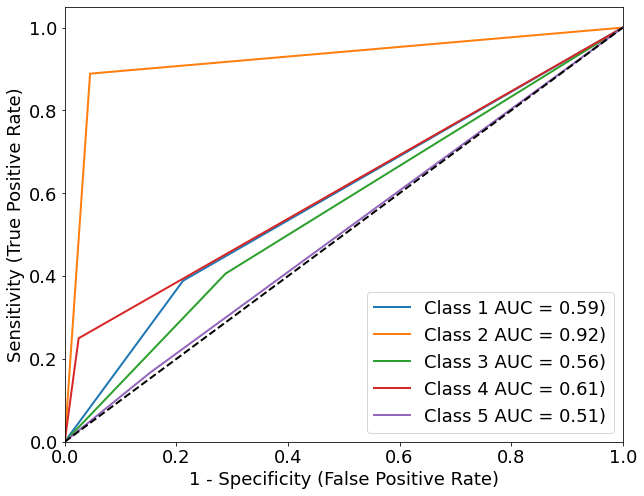

Accuracy MVDD: [0.77380952 0.92857143 0.61904762 0.92857143 0.77380952]
Averaged acc for all 5 classes: 0.8047619047619048


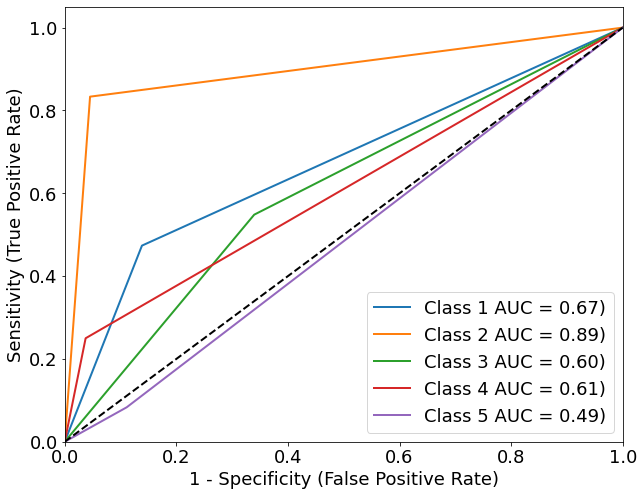

Accuracy MVDD: [0.75       0.95238095 0.60714286 0.95238095 0.78571429]
Averaged acc for all 5 classes: 0.8095238095238095


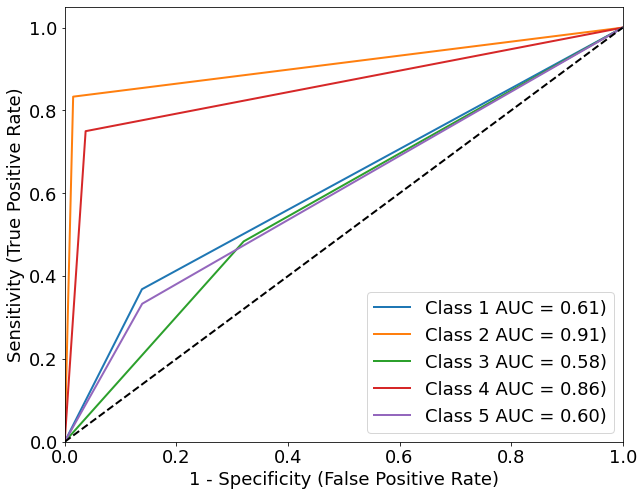

Accuracy MVDD: [0.72289157 0.98795181 0.60240964 0.98795181 0.78313253]
Averaged acc for all 5 classes: 0.816867469879518


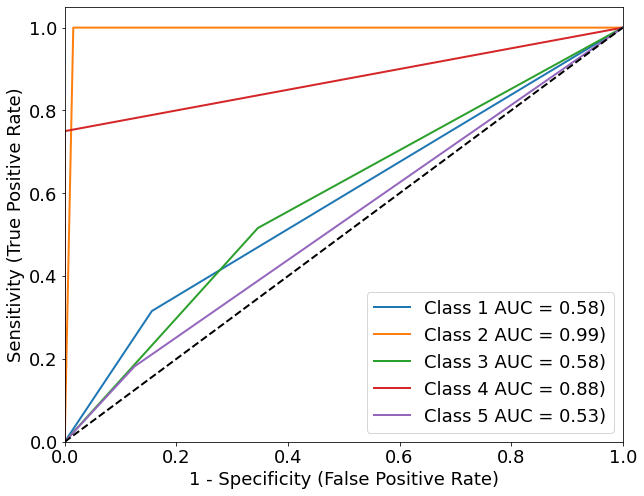

Accuracy MVDD: [0.79518072 0.89156627 0.72289157 0.89156627 0.75903614]
Averaged acc for all 5 classes: 0.8120481927710843


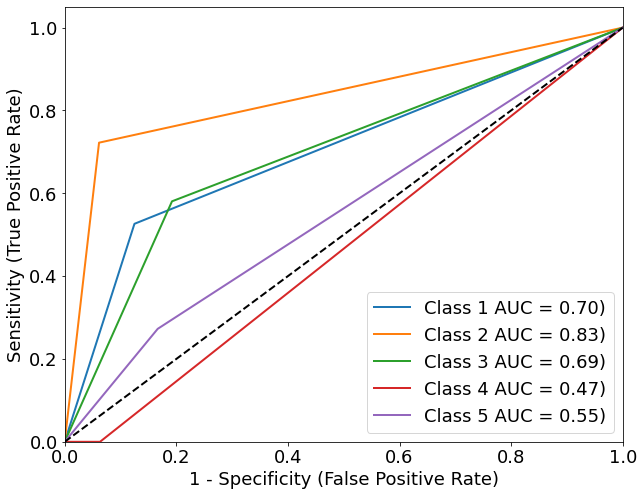

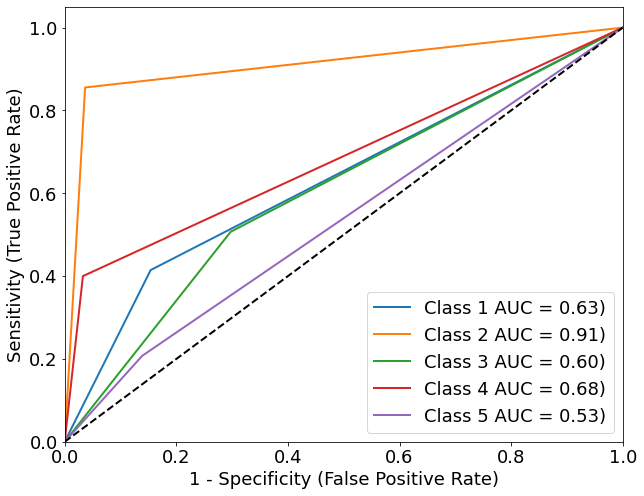


*****Averaged Final Classification Results*****
Sensitivity (TPR): 0.477(±0.523)
Specificity (TNR): 0.868(±0.204)
Precision (PPV): 0.483(±0.545)
Negative Predictive Value (NPV): 0.868(±0.199)
FPR: 0.132(±0.204)
FNR: 0.523(±0.523)
Accuracy: 0.806(±0.249)
Averaged AUC: 0.673(±0.303)


In [17]:
# base model decision tree

dt = DecisionTreeClassifier(random_state=100, max_depth=None)
dt_metrics = trainCrossVal(xData, yData, model=dt, numFolds=5, modelName=modelName+"DecisionTree", showIndividualROC=True)


Accuracy MVDD: [0.80952381 0.95238095 0.70238095 0.95238095 0.79761905]
Averaged acc for all 5 classes: 0.8428571428571429


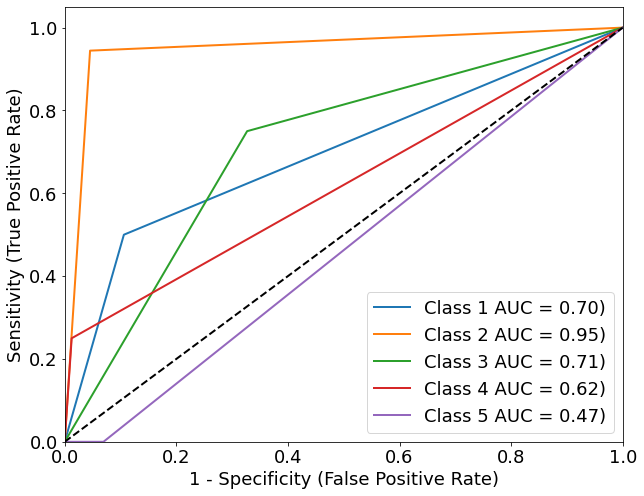

Accuracy MVDD: [0.71428571 0.94047619 0.57142857 0.94047619 0.85714286]
Averaged acc for all 5 classes: 0.8047619047619048


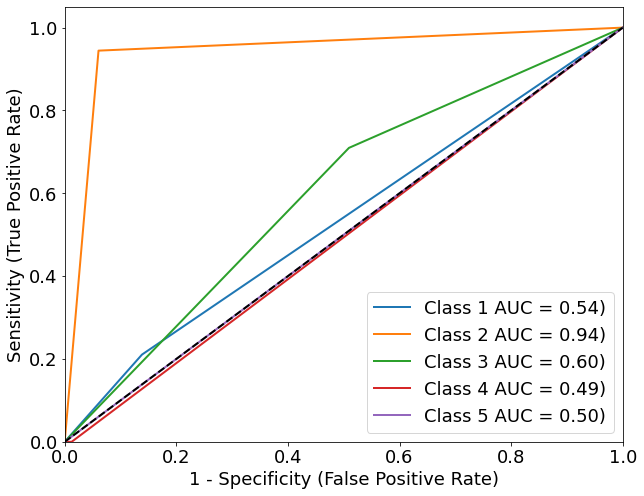

Accuracy MVDD: [0.80952381 0.95238095 0.69047619 0.95238095 0.85714286]
Averaged acc for all 5 classes: 0.8523809523809524


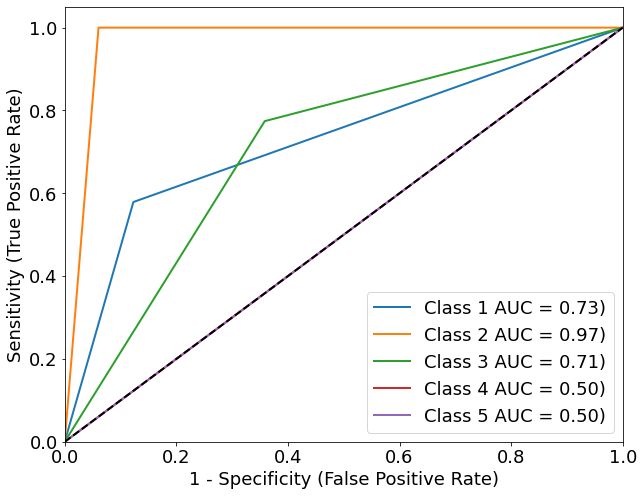

Accuracy MVDD: [0.75903614 0.93975904 0.63855422 0.93975904 0.8313253 ]
Averaged acc for all 5 classes: 0.8216867469879517


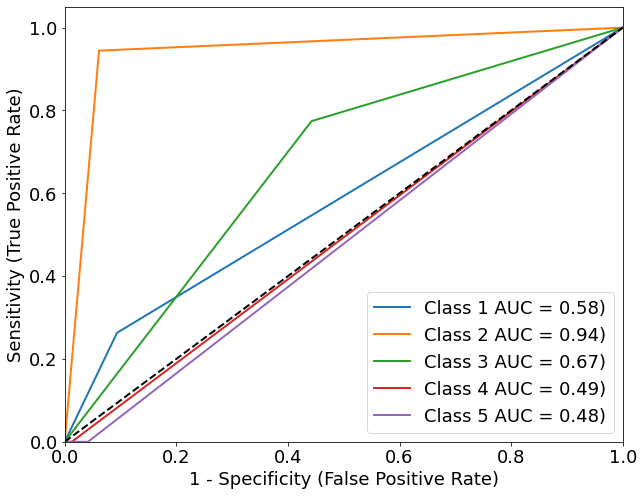

Accuracy MVDD: [0.80722892 0.93975904 0.6746988  0.93975904 0.81927711]
Averaged acc for all 5 classes: 0.8361445783132531


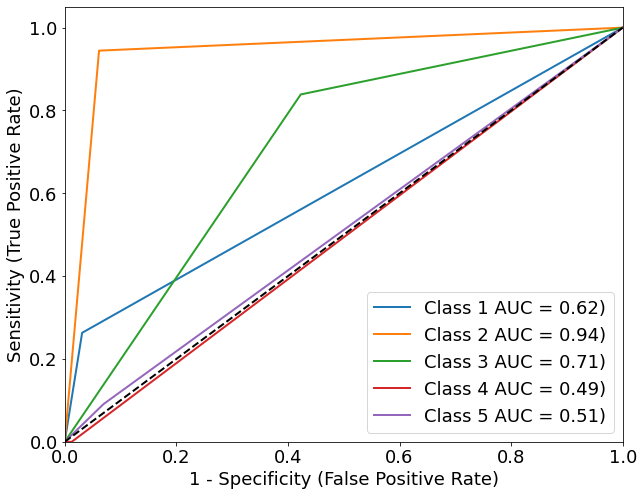

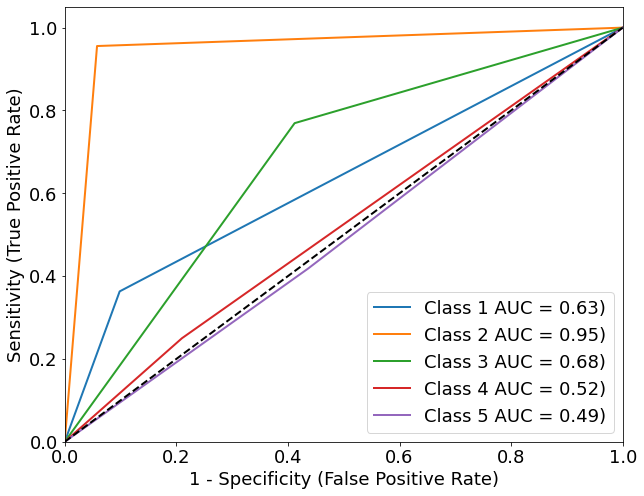


*****Averaged Final Classification Results*****
Sensitivity (TPR): 0.431(±0.772)
Specificity (TNR): 0.877(±0.304)
Precision (PPV): 0.456(±0.594)
Negative Predictive Value (NPV): 0.888(±0.147)
FPR: 0.123(±0.304)
FNR: 0.569(±0.772)
Accuracy: 0.832(±0.226)
Averaged AUC: 0.654(±0.337)


In [18]:
# random forest
rf = RandomForestClassifier(random_state=100, n_estimators=1000)
rf_metrics = trainCrossVal(xData, yData, model=rf, numFolds=5, modelName=modelName+"RandomForest", showIndividualROC=True)


In [19]:
# Make dataframe of stats
columns=["TPR", "TPR SD", "TPR CI", "TNR", "TNR SD", "TNR CI", "PPV", "PPV SD", "PPV CI",
             "NPV", "NPV SD", "NPV CI", "FPR", "FPR SD", "FPR CI", "FNR", "FNR SD", "FNR CI",
             "Acc", "Acc SD", "Acc CI", "AUC", "AUC SD", "AUC CI"]

mets = pd.DataFrame([knn_metrics, dt_metrics, rf_metrics], columns=columns)
mets.index = ["KNN", "DT", "RF"]
mets.to_csv("Model Comparison/" + modelName + "Results.csv")
mets

TPR    TPR SD    TPR CI       TNR    TNR SD    TNR CI       PPV  \
KNN  0.253810  0.308119  0.067269  0.810508  0.292851  0.075547  0.291974   
DT   0.476962  0.522776  0.020578  0.868067  0.204225  0.082252  0.482977   
RF   0.431250  0.772071  0.035548  0.877062  0.303589  0.083251  0.455735   

       PPV SD    PPV CI       NPV  ...    FPR CI       FNR    FNR SD  \
KNN  0.394758  0.061836  0.810754  ...  0.075547  0.746190  0.308119   
DT   0.544813  0.017689  0.867922  ...  0.082252  0.523038  0.522776   
RF   0.593814  0.028524  0.888189  ...  0.083251  0.568750  0.772071   

       FNR CI       Acc    Acc SD    Acc CI       AUC    AUC SD    AUC CI  
KNN  0.067269  0.726254  0.294094  0.064488  0.532159  0.097572  0.024313  
DT   0.020578  0.805783  0.248658  0.074970  0.672514  0.303405  0.056311  
RF   0.035548  0.831566  0.225654  0.078067  0.654156  0.337273  0.053231  

[3 rows x 24 columns]

# All Data

In [20]:
#Load original dataframes
allData = pd.read_csv('Data/Preprocessed Data/ESCAPE_AllData.csv', index_col='ID')
allScores = allData['Score']
death = allData['ScoreDeath']
rehosp = allData['ScoreRehosp']
readm = allData['ScoreReadmission']
allData

Age  Gender  Race          Wt        BMI  InitialHospDays  \
ID                                                                    
72.0     88.0     2.0   1.0   57.100000  26.424175              9.0   
72.0     88.0     2.0   1.0   52.000000  24.064047              9.0   
72.0     37.0     2.0   2.0   64.863709   0.000000              0.0   
81.0     69.0     1.0   1.0  102.363636  32.307675              5.0   
81.0     69.0     1.0   1.0  100.454545  31.705134              5.0   
...       ...     ...   ...         ...        ...              ...   
99302.0  41.0     1.0   2.0   97.400000  40.541103             21.0   
99912.0  46.0     1.0   1.0   78.636364  25.677180              2.0   
99912.0  46.0     1.0   1.0   78.200000  25.534694              2.0   
99935.0  64.0     2.0   1.0   77.700000  32.762692              3.0   
99935.0  64.0     2.0   1.0         NaN        NaN              3.0   

         TotalHospDays  NYHA  MLHFS   AF  ...     HR         PV         MAP  \
ID                                        ...                                 
72.0              16.0   4.0   76.0  1.0  ...  104.0  12.452563  139.333333   
72.0              16.0   3.0   76.0  1.0  ...   92.0  12.452563  126.000000   
72.0               0.0   3.0    0.0  1.0  ...    0.0   0.000000  118.000000   
81.0              13.0   4.0   21.0  1.0  ...   70.0  -3.346568  125.333333   
81.0              13.0   2.0   21.0  1.0  ...   72.0  -3.346568  105.666667   
...                ...   ...    ...  ...  ...    ...        ...         ...   
99302.0           21.0   NaN   79.0  0.0  ...   75.0  25.535155  130.000000   
99912.0            2.0   4.0   89.0  0.0  ...   67.0 -13.911732  174.666667   
99912.0            2.0   3.0   89.0  0.0  ...   60.0 -13.911732  140.666667   
99935.0           16.0   3.0  101.0  0.0  ...   86.0        NaN  135.333333   
99935.0           16.0   NaN  101.0  0.0  ...   87.0        NaN  153.333333   

           PP       PPP   PPRatio  Score  ScoreDeath  ScoreRehosp  \
ID                                                                  
72.0     26.0  0.276596  0.250000      3           1            2   
72.0     26.0  0.302326  0.282609      3           1            2   
72.0     28.0  0.341463  0.411765      1           2            3   
81.0     32.0  0.363636  0.457143      3           1            2   
81.0     34.0  0.441558  0.472222      3           1            2   
...       ...       ...       ...    ...         ...          ...   
99302.0  55.0  0.550000  0.733333      3           1            2   
99912.0  38.0  0.316667  0.567164      3           1            2   
99912.0  24.0  0.255319  0.400000      3           1            2   
99935.0  42.0  0.428571  0.488372      3           1            2   
99935.0  70.0  0.583333  0.804598      3           1            2   

         ScoreReadmission  
ID                         
72.0                    5  
72.0                    5  
72.0                    2  
81.0                    5  
81.0                    5  
...                   ...  
99302.0                 5  
99912.0                 5  
99912.0                 5  
99935.0                 5  
99935.0                 5  

[887 rows x 70 columns]

In [27]:
# Preprocess and create training and testing sets
alld = allData.drop('Score', axis=1)
alld = alld.drop('ScoreDeath', axis=1)
alld = alld.drop('ScoreRehosp', axis=1)
alld = alld.drop('ScoreReadmission', axis=1)
alld = alld.replace(np.inf, 0)
alld = alld.fillna(0)


## Readmission Outcome

In [22]:
xData = alld
yData = readm
xData.shape, yData.shape

modelName = "AllData_Readm_"

Accuracy MVDD: [1.         0.99438202 0.99438202 0.98876404]
Averaged acc for all 5 classes: 0.99438202247191


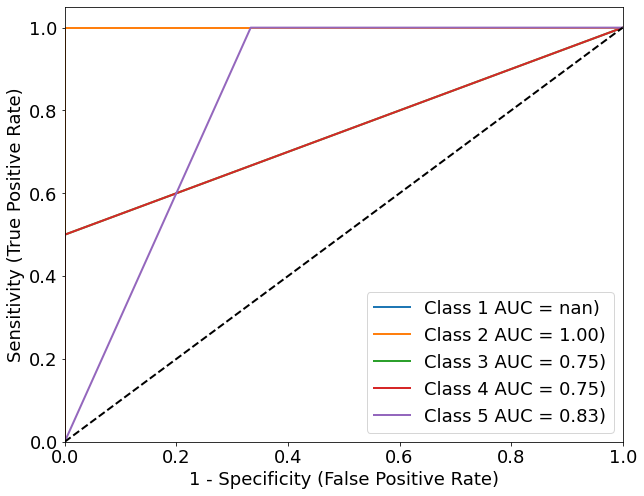

Accuracy MVDD: [0.99438202 0.99438202 0.98876404 0.99438202 0.98314607]
Averaged acc for all 5 classes: 0.9910112359550561


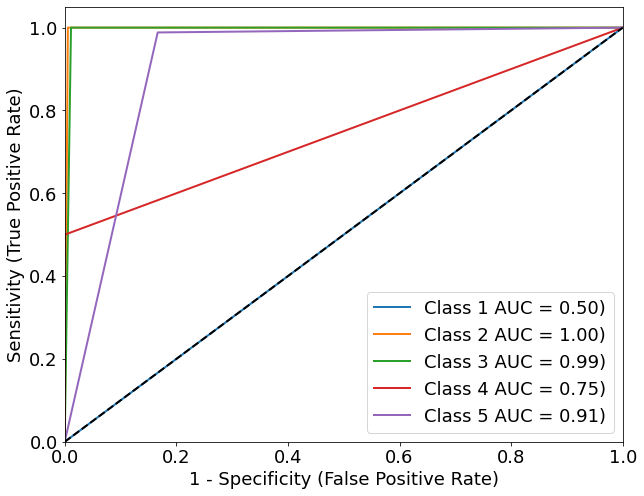

Accuracy MVDD: [0.99435028 0.98870056 0.99435028 0.98870056]
Averaged acc for all 5 classes: 0.9915254237288136


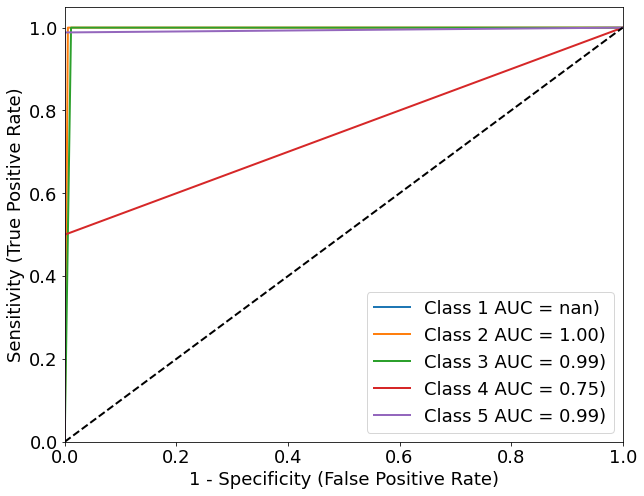

Accuracy MVDD: [0.99435028 0.99435028 0.99435028 0.99435028]
Averaged acc for all 5 classes: 0.9943502824858758


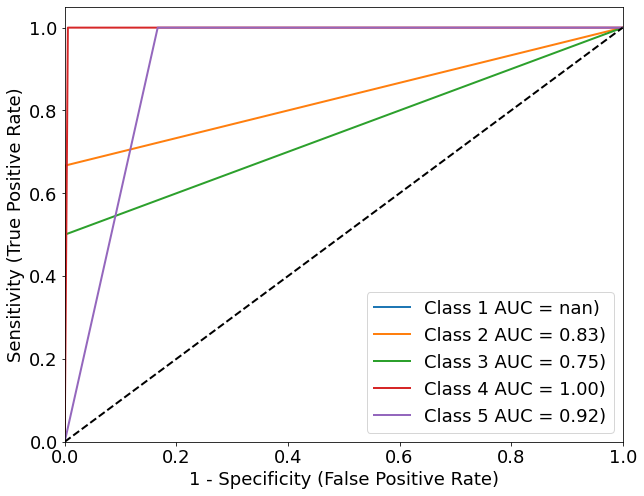

Accuracy MVDD: [0.98305085 0.98870056 0.98870056 0.98305085]
Averaged acc for all 5 classes: 0.9858757062146892


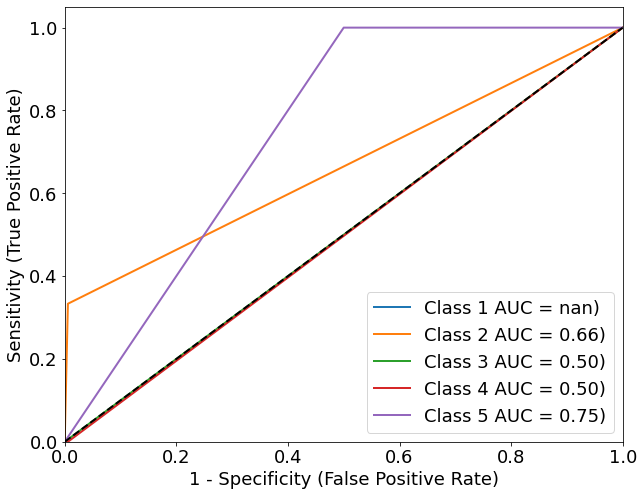

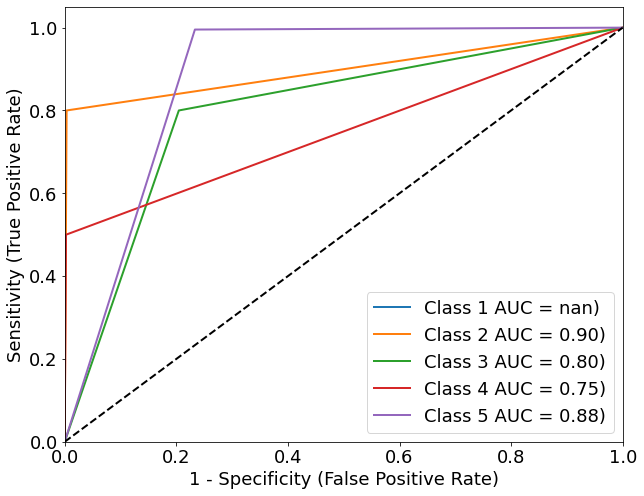

tpr list [array([1. , 0.5, 0.5, 1. ]), array([0.        , 1.        , 1.        , 0.5       , 0.98837209]), array([1.        , 1.        , 0.5       , 0.98837209]), array([0.66666667, 0.5       , 1.        , 1.        ]), array([0.33333333, 0.        , 0.        , 1.        ])]

*****Averaged Final Classification Results*****


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [29]:
# base model knn
knn = KNeighborsClassifier()
knn_metrics = trainCrossVal(xData, yData, model=knn, numFolds=5, modelName=modelName + "KNN", showIndividualROC=True)


Accuracy MVDD: [1. 1. 1. 1.]
Averaged acc for all 5 classes: 1.0


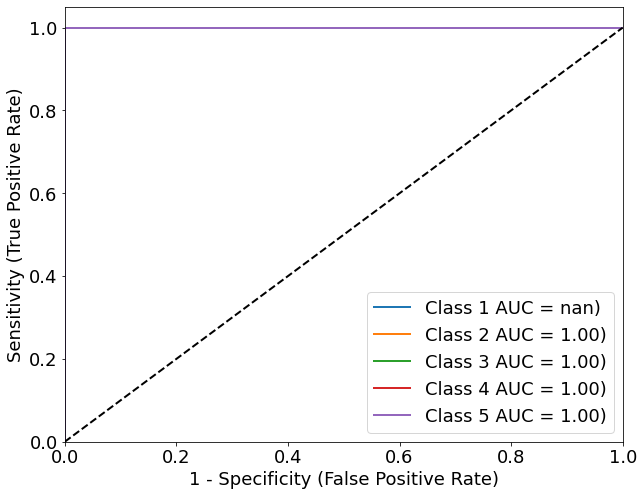

Accuracy MVDD: [0.99438202 0.98876404 0.99438202 0.99438202 0.99438202]
Averaged acc for all 5 classes: 0.9932584269662922


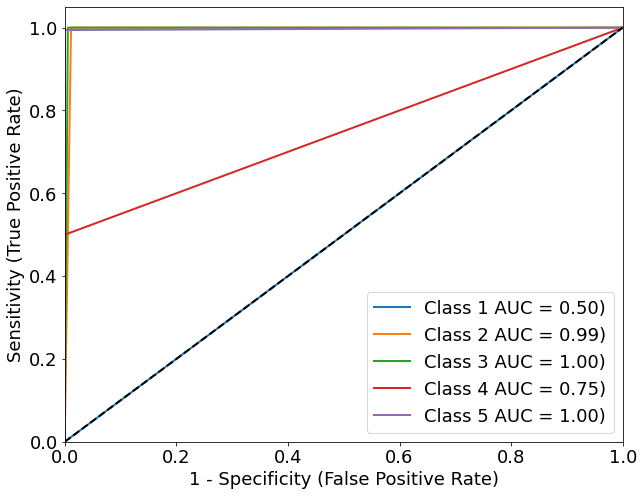

Accuracy MVDD: [0.99435028 0.98305085 1.         0.97740113]
Averaged acc for all 5 classes: 0.9887005649717515


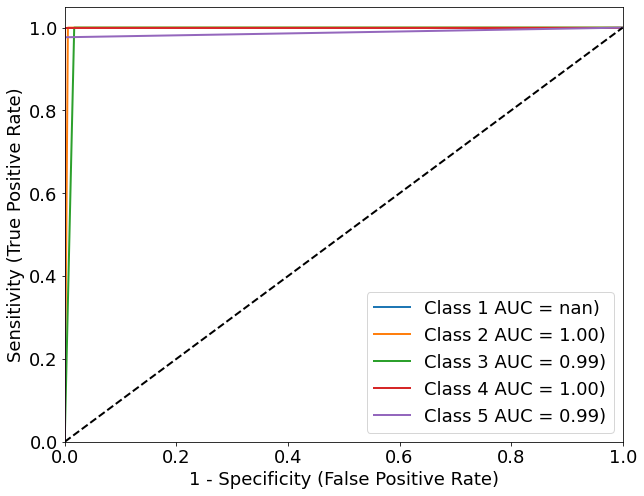

Accuracy MVDD: [0.99435028 0.98305085 0.99435028 0.98305085]
Averaged acc for all 5 classes: 0.9887005649717515


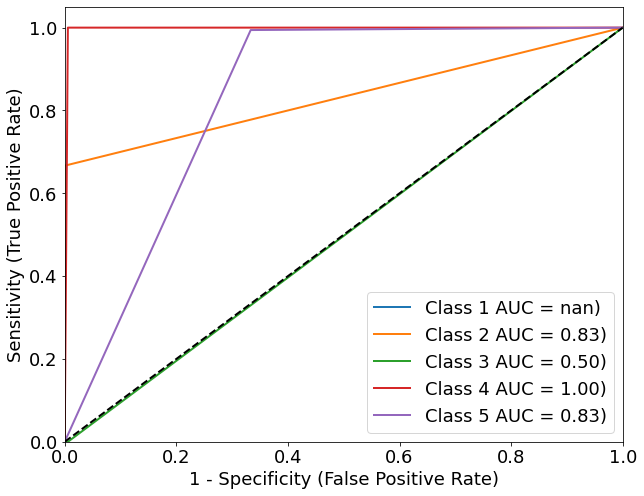

Accuracy MVDD: [0.98870056 0.99435028 0.99435028 0.98870056]
Averaged acc for all 5 classes: 0.9915254237288136


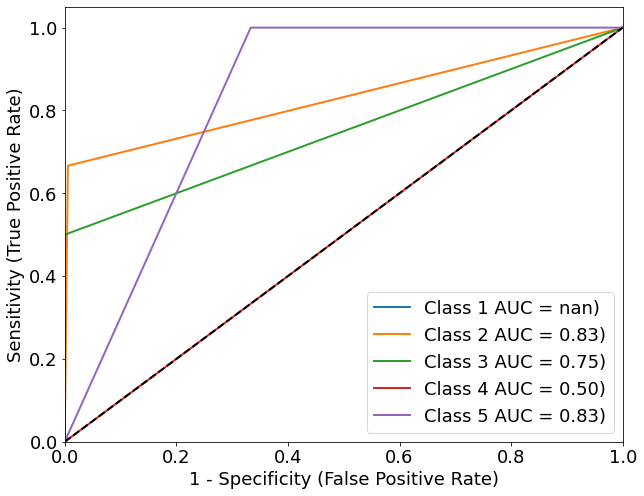

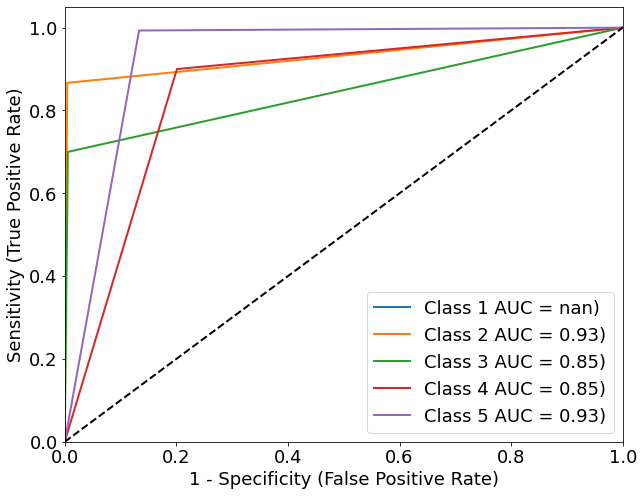


*****Averaged Final Classification Results*****


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [25]:
# base model decision tree

dt = DecisionTreeClassifier(random_state=100, max_depth=None)
dt_metrics = trainCrossVal(xData, yData, model=dt, numFolds=5, modelName=modelName+"DecisionTree", showIndividualROC=True)


Accuracy MVDD: [1.         0.99438202 1.         0.99438202]
Averaged acc for all 5 classes: 0.997191011235955


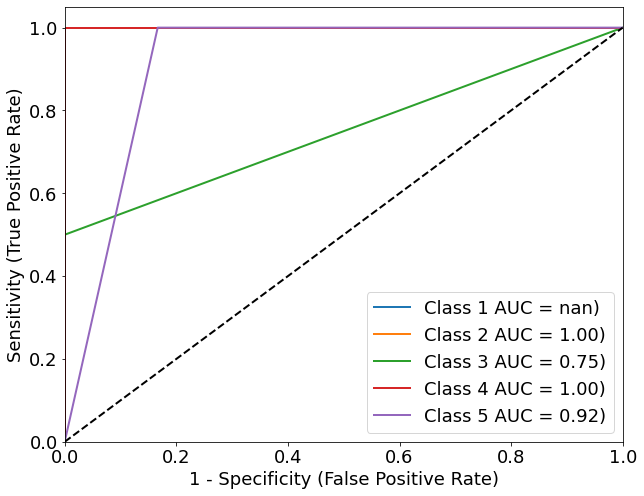

Accuracy MVDD: [0.99438202 0.99438202 0.99438202 0.99438202 0.98876404]
Averaged acc for all 5 classes: 0.9932584269662922


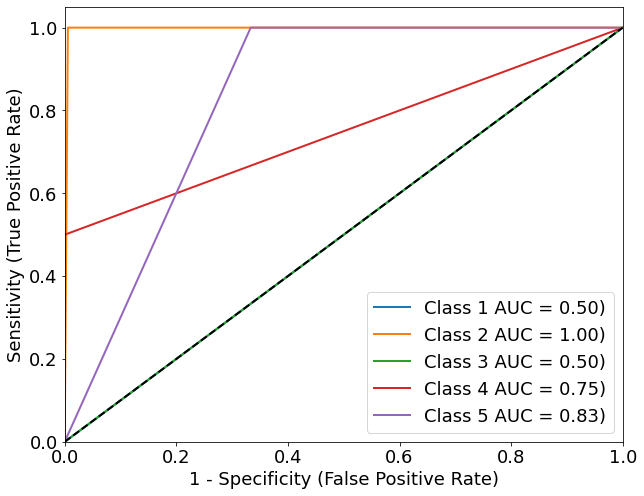

Accuracy MVDD: [0.99435028 0.99435028 0.99435028 0.99435028]
Averaged acc for all 5 classes: 0.9943502824858758


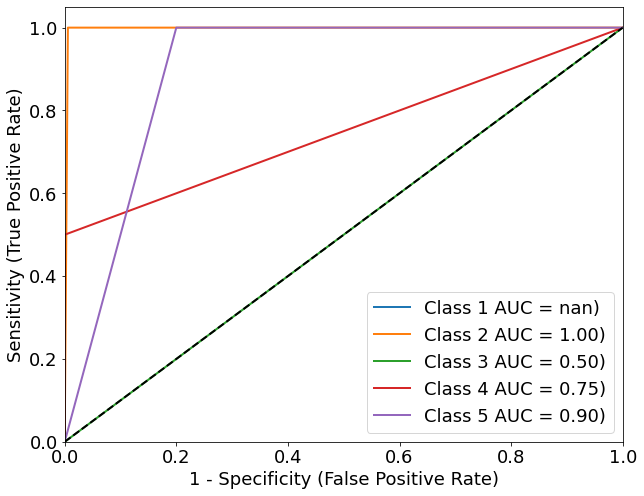

Accuracy MVDD: [0.98870056 0.98870056 0.98870056 0.98870056]
Averaged acc for all 5 classes: 0.9887005649717514


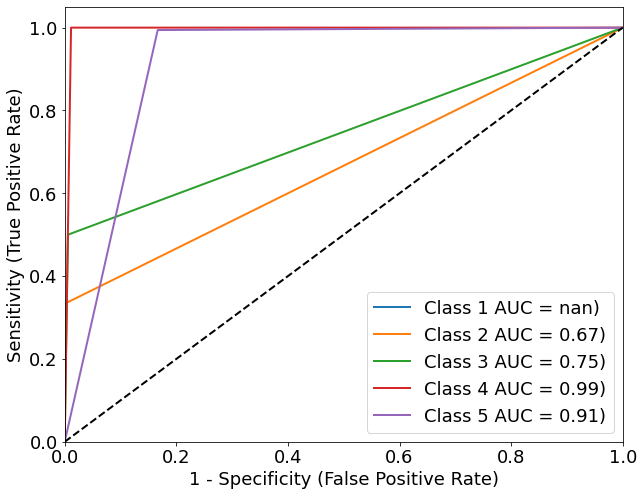

Accuracy MVDD: [0.98305085 0.98870056 0.98870056 0.98305085]
Averaged acc for all 5 classes: 0.9858757062146892


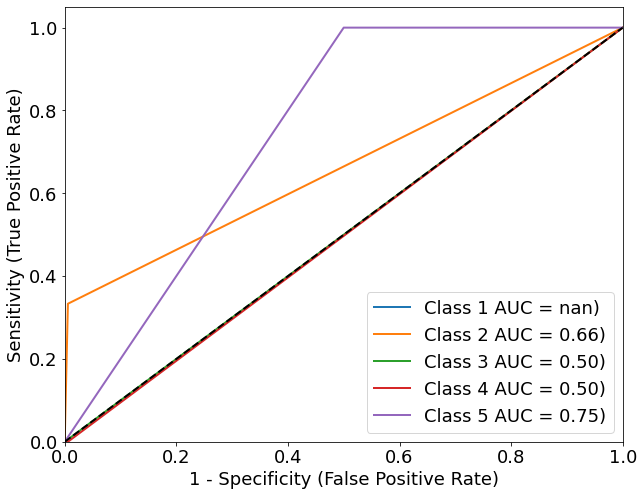

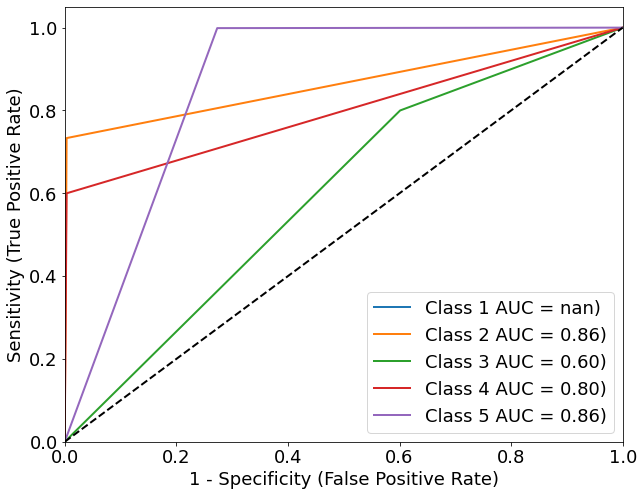


*****Averaged Final Classification Results*****


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [24]:
# random forest
rf = RandomForestClassifier(random_state=100, n_estimators=1000)
rf_metrics = trainCrossVal(xData, yData, model=rf, numFolds=5, modelName=modelName+"RandomForest", showIndividualROC=True)


In [ ]:
# Make dataframe of stats
columns=["TPR", "TPR SD", "TPR CI", "TNR", "TNR SD", "TNR CI", "PPV", "PPV SD", "PPV CI",
             "NPV", "NPV SD", "NPV CI", "FPR", "FPR SD", "FPR CI", "FNR", "FNR SD", "FNR CI",
             "Acc", "Acc SD", "Acc CI", "AUC", "AUC SD", "AUC CI"]

mets = pd.DataFrame([knn_metrics, dt_metrics, rf_metrics], columns=columns)
mets.index = ["KNN", "DT", "RF"]
mets.to_csv("Model Comparison/" + modelName + "Results.csv")
mets